In [1]:
import pandas as pd
import numpy as np
import scipy
from plotnine import *

import sklearn
from sklearn.tree import DecisionTreeClassifier, tree
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from pyomo.core import *
from pyomo.environ import *

import math
from pathlib import Path
from functools import partial, reduce
from typing import Union
import itertools
import os
import shutil
import collections
from collections import Counter, namedtuple, defaultdict
import re

import time

# Tree

## Rainy days tree

In [2]:
df_processed = pd.read_csv('data/q1.csv')
df_processed.head()

,temperature,humidity,sky,is_rain
0,Hot,High,Cloudy,1
1,Hot,High,Cloudy,1
2,Hot,High,Cloudy,1
3,Hot,High,Cloudy,1
4,Hot,High,Cloudy,1


In [3]:
df_processed = df_processed.apply(LabelEncoder().fit_transform)
df_processed.head()

,temperature,humidity,sky,is_rain
0,1,0,1,1
1,1,0,1,1
2,1,0,1,1
3,1,0,1,1
4,1,0,1,1


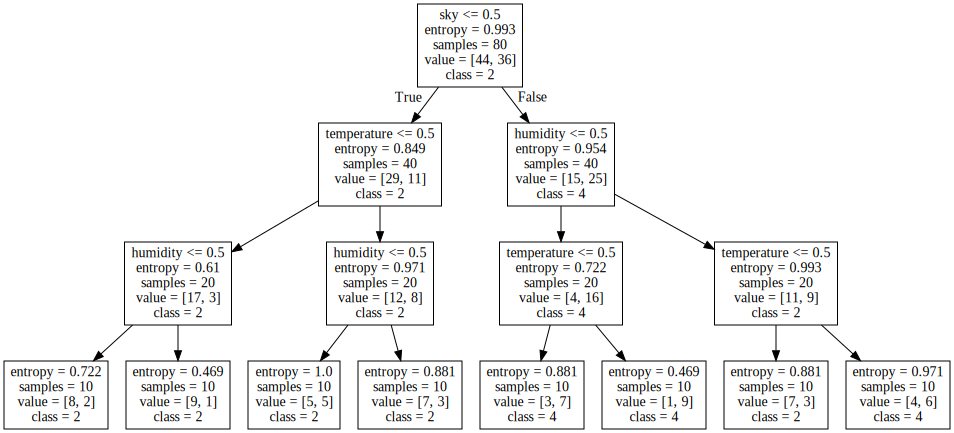

In [4]:
sklearn_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
sklearn_tree.fit(df_processed.drop('is_rain', axis=1), df_processed['is_rain'])
from graphviz import Source
Source(sklearn.tree.export_graphviz(sklearn_tree, class_names=['2', '4'],
       out_file=None, feature_names=df_processed.columns[:-1]))


## Tumour prediction

In [5]:
col_names = '''2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)
'''

col_names = col_names.splitlines()
pattern_name = re.compile('[a-zA-Z ]+')
col_names = ['_'.join(pattern_name.search(c).group(0)[1:].lower().split(' ')) for c in col_names]

In [6]:
path_data = Path('./data')
df_cancer_raw = pd.read_csv(path_data/'hw2_question1.csv', names=col_names)
print(df_cancer_raw.shape)
df_cancer_raw.head()

(683, 10)


,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [20]:
df_cancer_raw.tail()

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
678,3,1,1,1,3,2,1,1,1,2
679,2,1,1,1,2,1,1,1,1,2
680,5,10,10,3,7,3,8,10,2,4
681,4,8,6,4,3,4,10,6,1,4
682,4,8,8,5,4,5,10,4,1,4


In [7]:
def group_split(df, col, pct=0.33) -> namedtuple:
    split_col = df[col]
    split_unique = np.unique(split_col)
    all_indices = np.arange(df.shape[0])
    
    indices = np.array([], dtype=np.int16)
    for i in split_unique:
        group_indices = all_indices[split_col == i]
        selected_indices = np.random.choice(group_indices, round(group_indices.size*pct), replace=False)
        indices = np.hstack([indices, selected_indices])
        
    df_test = df.iloc[indices]
    df_train = df.loc[~np.isin(np.arange(df.shape[0]), indices)] #~np.isin(np.arange(df.shape[0]), indices)

    split_dfs = namedtuple('split_dfs', 'train test test_indices')
    return split_dfs(df_train, df_test, indices)

def x_and_resp(df, resp_col):
    X = df.drop(resp_col, axis=1)
    y = df[resp_col]
    return X, y

class Cross_Validation():
    
    def __init__(self, folds=10, random_state=1):
        self.folds = folds
        self.fold_indices_created = False
        self.random_state = random_state
    
    def create_fold_indices(self):
        np.random.seed(self.random_state)
        self.len = self.y.size
        self.fold_sizes = [int(self.len/self.folds) for i in range(self.folds)]
        self.fold_sizes[self.folds - 1] = self.len - (self.folds - 1) * self.fold_sizes[0]
        self.indices = np.arange(self.y.size)
        indices_tmp = np.arange(self.y.size)
        fold_indices = []
        for i in range(self.folds):
            f_i = np.random.choice(indices_tmp, self.fold_sizes[i], replace=False)
            fold_indices.append(f_i)
            indices_tmp = indices_tmp[~np.isin(indices_tmp, f_i)]
        self.fold_indices = fold_indices
        self.fold_indices_created = True
    
    def evaluate_cv(self, X, y, model):
        self.X = X
        self.y = y
        model_performace = []
        if not self.fold_indices_created:
            self.create_fold_indices()
        for i,f_i in enumerate(self.fold_indices):
            X_i = X.loc[~np.isin(np.arange(self.len), f_i)]
            y_i = y.loc[~np.isin(np.arange(self.len), f_i)]
            X_i_t = X.loc[np.isin(np.arange(self.len), f_i)]
            y_i_t = y.loc[np.isin(np.arange(self.len), f_i)]
            start = time.time()
            model.fit(X_i, y_i)
            model_performace.append({'accuracy':np.asscalar(model.score(X_i_t, y_i_t)), 
                                     'time':time.time()-start})
        self.model_performace = model_performace
        self._summarise_performace()
        print(self.summarised_metrics)
        return (self.model_performace, self.summarised_metrics)
    
    def _summarise_performace(self):
        summarised_metrics = {}
        for k in self.model_performace[0].keys():
            p = 0
            for fold in range(self.folds):
                p += self.model_performace[fold][k]
            summarised_metrics[k] = p/self.folds
        self.summarised_metrics = summarised_metrics
        
    def cv_grid_search(self, X, y, param_dict_list, model_type):
        order = param_dict_list.keys()
        df_grid_search = pd.DataFrame(list(itertools.product(*[param_dict_list[k] for k in order])), 
                                      columns=order)
        param_list = [dict(df_grid_search.iloc[i]) for i in range(df_grid_search.shape[0])]
        grid_res = {}
        grid_search_fold_results = {}
        for param_set in param_list:
            model = model_type(**param_set)
            print(model)
            eval_res = self.evaluate_cv(X, y, model)
            grid_res[model] = eval_res[1] #.__repr__()
            grid_search_fold_results[model.__repr__()] = eval_res[0]
        self.grid_search_results = grid_res
        self.grid_search_fold_results = grid_search_fold_results
        return self.grid_search_results
    
    def get_cv_grid_best_model(self, X, y, param_dict_list, model_type, metric_to_opt="accuracy", maximize=True):
        self.cv_grid_search(X, y, param_dict_list, model_type)
        z = zip([v[metric_to_opt] for k,v in self.grid_search_results.items()], 
                self.grid_search_results.keys())
        if maximize:
            metric = -float('Inf')
            param = None
            for v,k in z:
                if v > metric:
                    metric = v
                    param = k
        else:
            metric = float('Inf')
            param = None
            for v,k in z:
                if v < metric:
                    metric = v
                    param = k
        result = collections.namedtuple("best_model_performance", ["model", metric_to_opt, "all_metrics"])
        self.best_model = result(param, metric, self.grid_search_results[param])
        return self.best_model

### Splitting the data

In [37]:
def train_test_split_ml(data, test_size, seed=1):
    np.random.seed(seed)
    data_x = data[data.columns[:-1]].copy()
    data_y = data[['class']].copy()
    X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=test_size, stratify=data_y)
    return X_train, X_test, Y_train, Y_test

# train_x, test_x, train_y, test_y = train_test_split_ml(data, test_size = 0.33)


tr_X, ts_X, tr_y, ts_y  = train_test_split_ml(df_cancer_raw, 0.33)
# tr_X, tr_y = x_and_resp(df_tr, 'class')
# ts_X, ts_y = x_and_resp(df_ts, 'class')
# tr_X.shape
tr_X.shape
tr_X.head()

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
173,5,3,3,3,6,10,3,1,1
530,5,1,1,1,2,1,2,1,1
183,1,2,3,1,2,1,3,1,1
494,2,1,1,1,2,1,1,1,1
164,3,1,1,1,2,1,1,1,1


In [9]:
print('\nClass distribution overall')
print(tr_y.value_counts()+ts_y.value_counts())

print('\nClass distribution training data')
print(tr_y.value_counts(normalize=True))

print('\nClass distribution test data')
print(ts_y.value_counts(normalize=True))


print('\nSplit percent')
tr_y.shape[0]/(tr_y.shape[0] + ts_y.shape[0]), ts_y.shape[0]/(tr_y.shape[0] + ts_y.shape[0])


Class distribution overall
2    444
4    239
Name: class, dtype: int64

Class distribution training data
2    0.649891
4    0.350109
Name: class, dtype: float64

Class distribution test data
2    0.650442
4    0.349558
Name: class, dtype: float64

Split percent


(0.6691068814055637, 0.3308931185944363)

There are 444 observations of class 2 (benign) and 239 of class 4 (malignant). The classes are not evenly distributed. The classes make up about 65% and 35% respectively. As can be seen, after splitting the distribution is maintained. ALso, we can see that the split is 66% for training data and 33% for testing.

### Code for creating trees

In [10]:
class TreeClassifier():
    
    def __init__(self, split_cond='entropy', split_as_numeric=True, min_entropy=0.0, max_depth=math.inf):
        self.split_cond, self.split_as_numeric = split_cond, split_as_numeric
        self.min_entropy, self.max_depth = min_entropy, max_depth
        
    def fit(self, X, y):
        self.X, self.y = X.copy().reset_index(drop = True), y.copy().reset_index(drop = True)
        self.splits = self.create_splits()
        
    def entropy(self, x: np.ndarray):
        counts = np.unique(x, return_counts=True)[1]
        probs = counts/counts.sum()
        if self.split_cond == 'entropy':
            return -np.dot(probs, np.log2(probs))
        else:
            return 1-((probs**2).sum())
        
    def create_splits(self, indices=None):
        indices = np.arange(self.X.shape[0]) if indices is None else indices
        
        split_info = namedtuple('split_info', 'feature splitval cat nodes')
        
        cats, counts = np.unique(self.y.loc[indices].values, return_counts=True)
        cat = np.asscalar(cats[counts == counts.max()][0])
        
        if self.entropy(self.y.loc[indices]) <= self.min_entropy:
            return split_info(None, None, cat, [None, None])
        else:
            feature, split_value, best_entropy = self.get_best_split(indices)
            left_indices = indices[self.X.loc[indices][feature] <= split_value]
            right_indices = indices[self.X.loc[indices][feature] > split_value]
            
            l = self.create_splits(left_indices)
            r = self.create_splits(right_indices)
            
            return split_info(feature, split_value, cat, [l, r])
        
    def get_best_split(self, current_indices):
        entropies = self.calc_entropies_cols(current_indices)
        best_entropy = math.inf
        for c in sorted(self.X.columns, reverse=True):
            splitpoint_entropies = entropies[c]
            for s, e in splitpoint_entropies.items():
                if e < best_entropy:
                    best_entropy, feature, splitpoint = e, c, s
#         print(feature, '<=', splitpoint) #, ':', best_entropy
        return feature, splitpoint, best_entropy

    def calc_entropies_cols(self, current_indices):
        return {c:self.calc_entropies_col(c, current_indices) for c in self.X.columns}

    def calc_entropies_col(self, split_colname, current_indices):
        X = self.X.loc[current_indices]
        split_col = X[split_colname]
        levels, probs = self.get_split_points(split_col)
        y = self.y.loc[current_indices]
        
        entropies = defaultdict(int)
        for l, p in zip(levels, probs):
            selected_level = split_col <= l if self.split_as_numeric else split_col == l
            entropies[l] = p * self.entropy(y[selected_level]) + (1-p) * self.entropy(y[~selected_level]) 
        return entropies
     
    def get_split_points(self, split_col):
        levels, counts = np.unique(split_col, return_counts=True)
        probs = counts/counts.sum()
        
        if self.split_as_numeric:
            new_levels = []
            new_probs = []
            for i in range(levels.size-1):
                new_levels.append((levels[i] + levels[i+1])/2)
                new_probs.append(probs[i] if len(new_probs) == 0 else new_probs[i-1]+probs[i])
            return np.array(new_levels), np.array(new_probs)
        else:
            return levels, probs

    def evaluate(self, ts_X, ts_y):
        preds = self.predict(ts_X)
        return (ts_y == preds).mean()            
               
    def predict(self, ts_X):
        return ts_X.apply(self.predict_rec, axis=1)

    def predict_rec(self, rec):
        split = self.splits
        current_depth = 0
        while (getattr(split, 'nodes') != [None, None]) and (current_depth <= self.max_depth):
            f, v, c, ns = split
            split = ns[0] if rec[f]<=v else ns[1]
            current_depth += 1
        return getattr(split, 'cat')

In [11]:
my_tree = TreeClassifier(split_cond='gini')
my_tree.fit(tr_X, tr_y)
my_tree.evaluate(ts_X, ts_y)

0.9424778761061947

In [38]:
my_tree = TreeClassifier(split_cond='entropy')
my_tree.fit(tr_X, tr_y)
my_tree.evaluate(ts_X, ts_y)

0.9424778761061947

#### Verification with scikit learn

In [47]:
tr_X_cp = tr_X.copy()
sklearn_tree = DecisionTreeClassifier(criterion='gini')
sklearn_tree.fit(tr_X_cp, tr_y)
print(sklearn_tree.score(ts_X, ts_y))


0.9336283185840708


0.9557522123893806


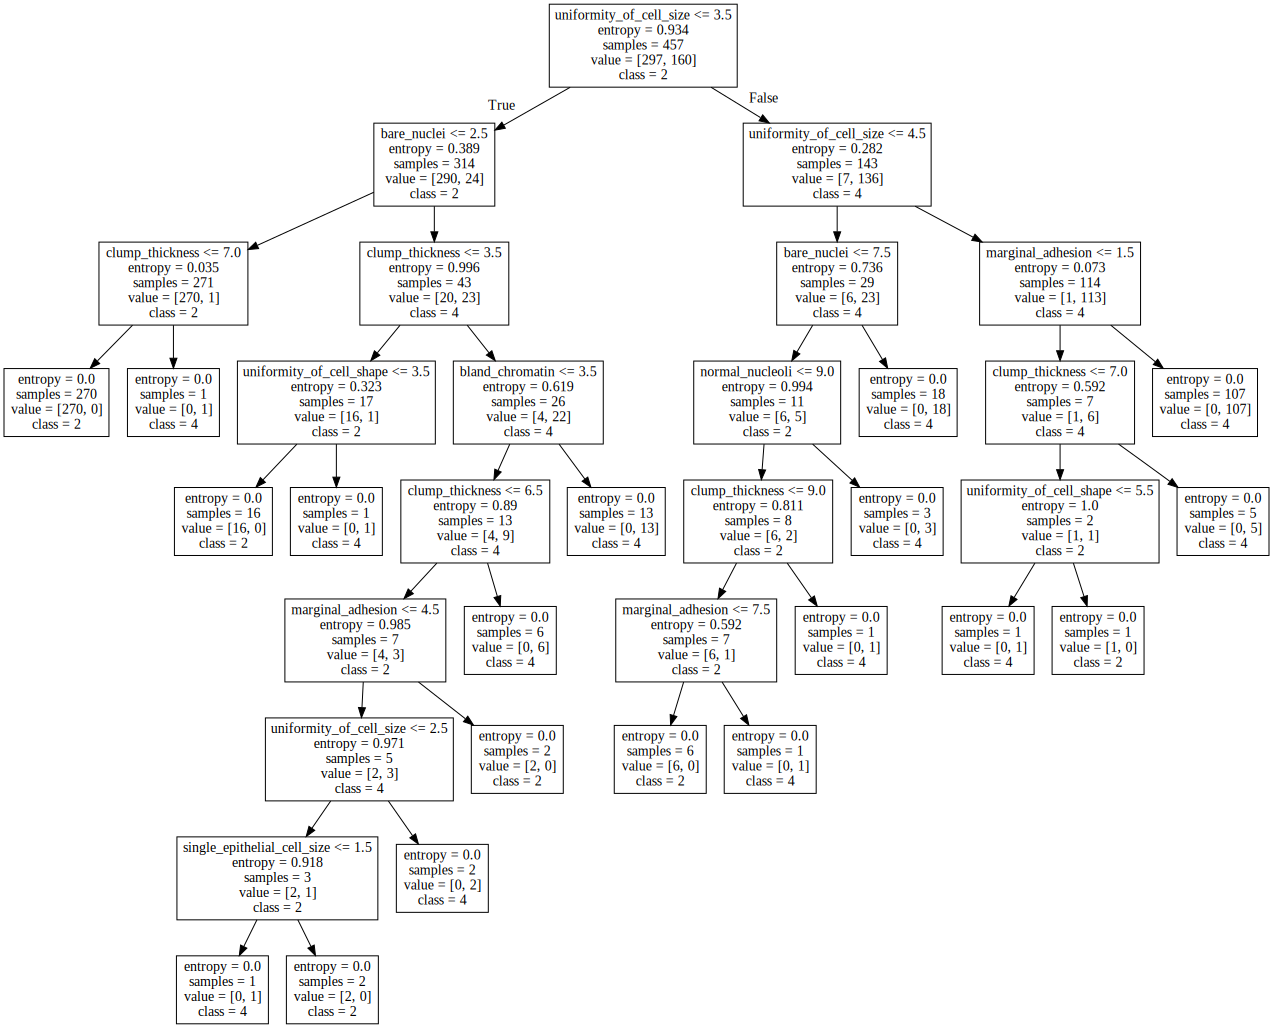

In [39]:
tr_X_cp = tr_X.copy()
sklearn_tree = DecisionTreeClassifier(criterion='entropy')
sklearn_tree.fit(tr_X_cp, tr_y)
print(sklearn_tree.score(ts_X, ts_y))

from graphviz import Source
Source(sklearn.tree.export_graphviz(sklearn_tree, class_names=['2', '4'],
       out_file=None, feature_names=tr_X_cp.columns))


### Accuracies at different depths

In [101]:
def get_accuracies_at_depths(model, depths = range(1, 11)):
    training_acc = []
    testing_acc = []
    for d in depths:
        model.max_depth = d
        model.fit(tr_X, tr_y)
        training_acc.append(model.evaluate(tr_X, tr_y))
        testing_acc.append(model.evaluate(ts_X, ts_y))
#         ans[d]  = [model.evaluate(tr_X, tr_y), model.evaluate(ts_X, ts_y)]
    return pd.DataFrame({'depth':depths, 'training':training_acc, 'testing':testing_acc})

df_accs_entr = get_accuracies_at_depths(TreeClassifier(split_cond='entropy')).assign(split_cond='entropy')
df_accs_gini = get_accuracies_at_depths(TreeClassifier(split_cond='gini')).assign(split_cond='gini')

In [123]:
df_accs = (pd.concat([df_accs_entr, df_accs_gini])
           .reset_index()
           .melt(id_vars=['depth', 'split_cond'], 
                 var_name='data')
           .query('data!="index"'))

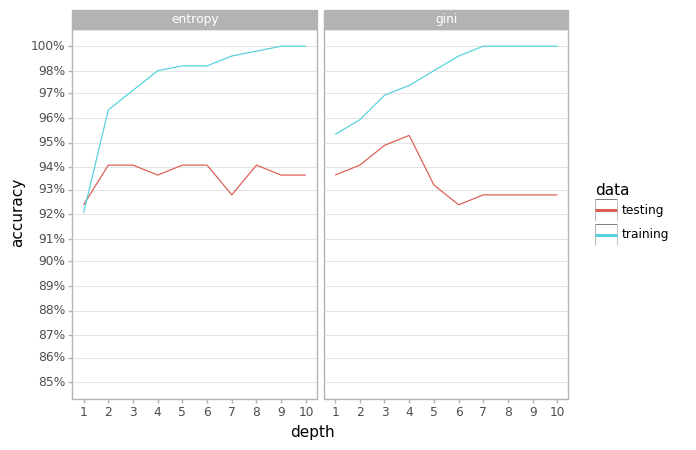

<ggplot: (8754510726948)>

In [150]:
(ggplot(aes('depth', 'value', color='data'), data=df_accs) +
 geom_line() +
 facet_wrap('~split_cond') +
 scale_x_continuous(breaks=range(11)) +
 scale_y_continuous(limits=[0.85, 1],
                    breaks=np.linspace(0.85, 1, 15).round(3),
                    labels=lambda l: ["%d%%" % (v * 100) for v in l]) +
 labs(y='accuracy') +
 theme_light() +
 theme(
     panel_grid_minor=element_blank(),
     panel_grid_major_x=element_blank())
 )

As we expected the training accuracy increases as the depth increases. However, as the tree begins to overfit, the testing accuracy drops. Both the spitting criteria reflect this trend as evident from the similar plots. We don't see any practical differences between them. 

## Bonus: Prepruning

In [51]:
my_tree = TreeClassifier(split_cond='entropy', min_entropy=0.2)
my_tree.fit(tr_X, tr_y)
my_tree.evaluate(ts_X, ts_y)

0.9513274336283186

By adding the `min_entropy` argument we can achieve pre-pruning. Internally, the implemented algorithm stops splitting a node when the mentioned entropy is achieved. 

# SVM

## Preprocessing

In [152]:
df_phishing = pd.read_csv(path_data/'hw2_question3.csv', header=None)
df_phishing.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


### One hot encoding

In [153]:
df_phishing = pd.get_dummies(df_phishing, columns=df_phishing.columns.values[:-1])
df_phishing['30'] = df_phishing[30]
df_phishing = df_phishing.drop(30, axis=1)
df_phishing.head()

,0_-1,0_1,1_-1,1_0,1_1,2_-1,2_1,3_-1,3_1,4_-1,...,26_-1,26_1,27_-1,27_1,28_-1,28_0,28_1,29_-1,29_1,30
0,1,0,0,0,1,0,1,0,1,1,...,1,0,0,1,0,0,1,1,0,-1
1,0,1,0,0,1,0,1,0,1,0,...,1,0,0,1,0,0,1,0,1,-1
2,0,1,0,1,0,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,-1
3,0,1,0,1,0,0,1,0,1,0,...,1,0,0,1,1,0,0,0,1,-1
4,0,1,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,1,1


### Splitting into training and test sets

In [154]:
df_tr, df_ts, _ = group_split(df_phishing, '30')
tr_X, tr_y = x_and_resp(df_tr, '30')
ts_X, ts_y = x_and_resp(df_ts, '30')
tr_X.shape, ts_X.shape

((7407, 68), (3648, 68))

## Linear SVM

In [206]:
param_dict_list = {
    'kernel': ['linear'],
    'C' : np.arange(1e-6, 1+1e-6, 0.1).tolist() 
}
cv = Cross_Validation(folds=3)
cv.get_cv_grid_best_model(tr_X, tr_y, param_dict_list, SVC)

SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
{'accuracy': 0.5569056298096395, 'time': 2.2957801024119058}
SVC(C=0.100001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
{'accuracy': 0.935466450654786, 'time': 0.4734652837117513}
SVC(C=0.200001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
{'accuracy': 0.9357364655056029, 'time': 0.46132699648539227}
SVC(C=0.300001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=

best_model_performance(model=SVC(C=0.500001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False), accuracy=0.9365465100580531, all_metrics={'accuracy': 0.9365465100580531, 'time': 0.49436148007710773})

As we can see, the best performance (accuracy=93.65%) is at C=0.5 for a support vector machine with a linear kernel.

In [213]:
df_res = pd.DataFrame(sum(cv.grid_search_fold_results.values(), []))
df_res['C'] = np.arange(1e-6, 1+1e-6, 0.1).repeat(3)
df_res = df_res.groupby('C').aggregate('mean').reset_index()
df_res

,C,accuracy,time
0,0.000001,0.556906,2.295780
1,0.100001,0.935466,0.473465
2,0.200001,0.935736,0.461327
3,0.300001,0.936276,0.451955
4,0.400001,0.936276,0.464010
5,0.500001,0.936547,0.494361
6,0.600001,0.936547,0.501599
7,0.700001,0.936141,0.518268
8,0.800001,0.935871,0.504017
9,0.900001,0.936006,0.500374


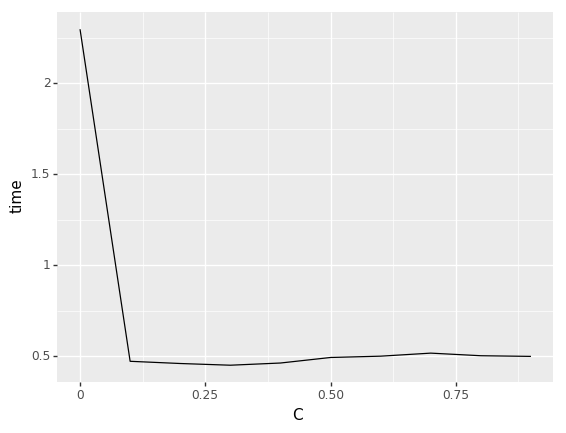

<ggplot: (-9223363282343102376)>

In [214]:
ggplot(aes('C', 'time'), data=df_res) + geom_line()

Training time is 2.3 seconds for C almost 0 and close to 0.5 seconds for other values. 

In [215]:
model_svm = SVC(kernel='linear', C=0.35)
model_svm.fit(tr_X, tr_y)
model_svm.score(ts_X, ts_y)

0.9407894736842105

We get an accuracy of 94% on the test set.

## Other kernels

In [216]:
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4, 5],
    'gamma': ['auto', 'scale']
}

# cv = Cross_Validation(folds=3)
# cv.get_cv_grid_best_model(tr_X, tr_y, param_dict_list, SVC)


cv_svm = GridSearchCV(model_svm, param_grid, n_jobs=-1, cv=3)
cv_svm.fit(tr_X, tr_y)
print(cv_svm.best_params_, cv_svm.best_score_)
print(cv_svm.score(ts_X, ts_y))

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'} 0.9464020521128662
0.9627192982456141


The 'rbf' (radial basis function/gaussian) kernel is the most effective. It achieves an accuracy of 96.27% at C=10. 

## Bonus

In [217]:
class SVM_LINEAR():
    
    def __init__(self, C=1):
        self.C = C
    
    def fit(self, X, y):
        self.X, self.y = X.copy().values, y.copy().values
        self.solve_alpha()
        self.get_weights_from_alpha()
    
    @property
    def N(self):
        return self.X.shape[0]
    
    def predict(self, ts_X):
        preds = ((self.w.dot(ts_X.T) + self.w0)>0)*1
        preds[preds == 0] = -1
        return preds
    
    def evaluate(self, ts_X, ts_y):
        return (self.predict(ts_X) == ts_y).mean()
    
    def get_weights_from_alpha(self):
        s = np.vstack([np.array(self.alpha[i] * self.X[i] * self.y[i]) for i in range(self.N)])
#         print(s.shape)
        self.w = s.sum(axis=0)
        self.w0 = (self.y - self.w.dot(self.X.T)).mean()
        
    def dual_objective(self, model):
        term_1 = []
        term_2 = []
        for i in range(self.N):
            for j in range(self.N):
                XtX = self.X[i].dot(self.X[j])
                YnYm = self.y[i]* self.y[j]
                AnAm = model.alpha[i]*model.alpha[j]
                term_1.append(XtX * YnYm * AnAm)
#                 print(XtX * YnYm * AnAm)
            term_2.append(model.alpha[i])  
        obj = ((-1/2)*sum(term_1)) + sum(term_2)
        return obj
    
    def cons_rule(self, model):
        cons_lhs = []
        for i in range(self.N):
            a = model.alpha[i]
            y = self.y[i]
            cons_lhs.append(a*y)
        cons_lhs = sum(cons_lhs)
        return (cons_lhs == 0)  
             
    def solve_alpha(self):
        model = ConcreteModel()
        model.alpha = Var(range(self.N), bounds=(0, self.C), within=NonNegativeReals)
        model.constraint = Constraint(rule=self.cons_rule)
        model.objective = Objective(rule=self.dual_objective, sense=maximize)
        solver = SolverFactory('ipopt')
        status = solver.solve(model)
        self.opt = model
        self.alpha = np.array([model.alpha[i].value for i in range(self.N)])


In [218]:
N = 1000 
model_svm_mine = SVM_LINEAR()
model_svm_mine.fit(tr_X[:N], tr_y[:N])   
p = model_svm_mine.predict(tr_X)
model_svm_mine.evaluate(ts_X, ts_y)

0.8678728070175439

### Verifying with scikit

In [219]:
model_svm = SVC(kernel='linear', gamma='auto')
model_svm.fit(tr_X[:N], tr_y[:N])
model_svm.score(ts_X, ts_y)

0.8643092105263158

As we can see the performance when we train with the first 1000 values is more or less similar. For bigger training sets, my SVM model begins to freeze. 